# Blurred Image Detection via Supervised Learning Using Different Approaches

### Project Description
There is a dataset of images, par of which is blurred. The task is to develop a machine learning algorithm to detect whether the image is blurred or sharp on the unknown dataset.

### Data Description
The dataset consists of images, and some of them are blurred. The images are blurred using augmentation.

Data files:
- ```train``` - a folder for training
- ```test``` - a folder with images, for which we make predicitons
- ```train.csv``` - labels (answers) to the train sample: **if 1, the image is blurred.**

### Project Methodology

There are two approaches, which can be applied to solving a classification problem for blurred image detection:
- 1) To use  Laplacian or Fourier algorithms to construct the algorithm for interating through the dataset and detecting the blurred images by an advised threshold from the research literature (Liu, 2008; Hsu, 2008, Su et al., 2011). To test manually the predictions.
- 2) To construct a convolutional neural network, train and test it on unseen given test sample. The quality metric is 'accuracy'; the overfitting problem is to be considered; data augmentation is used to prevent overfitting.

#### Final project output: ***a .csv file with predictions for a test (unseen) data.***

### Data
Dataset can be found [here](https://drive.google.com/drive/folders/1CWsLeFXwthxo7n5j6CYZlW_cS9X0oFVP?usp=share_link).


### Project Team: _Mayank, Ruba, Yulia, Dharmaraj, Jay

### Papers:
- [Hsu, P., & Chen, B. Y. (2008, January). Blurred image detection and classification. In International conference on multimedia modeling (pp. 277-286). Springer, Berlin, Heidelberg.](https://jiaya.me/all_final_papers/blur_detect_cvpr08.pdf)
- [Su, B., Lu, S., & Tan, C. L. (2011, November). Blurred image region detection and classification. In Proceedings of the 19th ACM international conference on Multimedia (pp. 1397-1400).](https://fled.github.io/paper/blur.pdf)
- [Liu, R., Li, Z., & Jia, J. (2008, June). Image partial blur detection and classification. In 2008 IEEE conference on computer vision and pattern recognition (pp. 1-8). IEEE.](http://graphics.im.ntu.edu.tw/docs/mmm08.pdf)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
plt.style.use('dark_background')
import seaborn as sns
import ssl
#import torch
import glob

from ipyplot import plot_images
from pylab import *
from PIL import Image
from sklearn.utils import shuffle
from keras.models import Sequential
from tqdm.keras import TqdmCallback
from keras.preprocessing import image
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore")

# show the version of tf
print(cv2.__version__)

2023-03-31 21:29:27.310064: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-31 21:29:27.370789: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 21:29:27.650699: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-31 21:29:27.652197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 21:29:28.698452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

4.7.0


/usr/lib/python3/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 Data Load

### 1.1 Loading images and labels from given datasets

In [2]:
labels = pd.read_csv('/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/train.csv')
labels.head()

,filename,blur
0,kagouracdzwrjjxzzedi.jpg,0.0
1,ahnamimqdfqoqdnozabc.jpg,0.0
2,gwhdadvghuzinmzhzssx.jpg,0.0
3,onqwabwwckubrydgbzly.jpg,0.0
4,ewpqdruddbokqyzzupcw.jpg,1.0


### Which batch_size value to put?
The best batch size to select depends on the application and the available resources (such as memory and computational power).

A larger batch size can result in faster training times, as more samples can be processed at once. However, it also increases the memory requirements of the model, and can result in a less accurate solution. A smaller batch size can result in more accurate solutions, but requires more training iterations and therefore takes longer to train.

In general, a batch size of 32 or 64 is a good starting point for most applications. For large datasets, batch sizes of 128 or 256 are common. However, it's important to keep in mind that the optimal batch size can vary depending on the complexity of the model and the specific characteristics of the dataset.

A common practice is to try different batch sizes and evaluate the performance of the model using a validation set. A batch size that results in the best performance on the validation set is likely to be a good choice for the final model.

It's also worth noting that when using large batch size, it's essential to use a technique called "Batch Normalization" as it helps to normalize the inputs to the model, which can improve the stability of the training process.

**In summary, the best batch size is not a fixed value and it's a hyperparameter that can be fine-tuned during model development. It's depend on resources, dataset and the complexity of the model.**


In [3]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2
)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

# To extract the data using ImageDataGenerator()
# using flow_from_directory():

train_datagen_flow = train_datagen.flow_from_directory(
    '/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345)

val_datagen_flow = validation_datagen.flow_from_directory(
    '/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    seed=12345)

Found 2579 images belonging to 6 classes.
Found 859 images belonging to 6 classes.


#### Choosing the right batch size for the model can have a big impact on the training performance and final accuracy.

### 1.2 Exploratory Data Analysis

#### 1.2.1 Understanding the variables type, labels structure, number of target classes.

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  2664 non-null   object 
 1   blur      2664 non-null   float64
dtypes: float64(1), object(1)
memory usage: 41.8+ KB


In [5]:
labels['blur'].unique()

array([0., 1.])

In [6]:
print(len(labels))

2664


#### 1.2.2 Descriptive statistics of labels

In [7]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
blur,2664.0,0.486862,0.499921,0.0,0.0,0.0,1.0,1.0


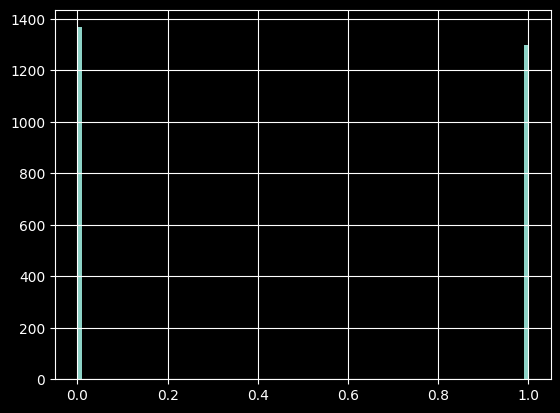

In [8]:
labels['blur'].hist(bins=100);

#### 1.2.3 Checking the target value for missing and duplicates

In [9]:
labels.isna().sum()

filename    0
blur        0
dtype: int64

In [10]:
labels.duplicated().sum()

0

#### 1.2.4  Checking the target value for disbalance

In [11]:
labels_df = pd.DataFrame(labels)

In [12]:
labels_df['blur'].value_counts()

0.0    1367
1.0    1297
Name: blur, dtype: int64

In [13]:
train_blur = labels[labels["blur"]==1]
train_sharp = labels[labels["blur"]==0]

print("Blur images:", len(train_blur))
print("Sharp images:", len(train_sharp))

Blur images: 1297
Sharp images: 1367


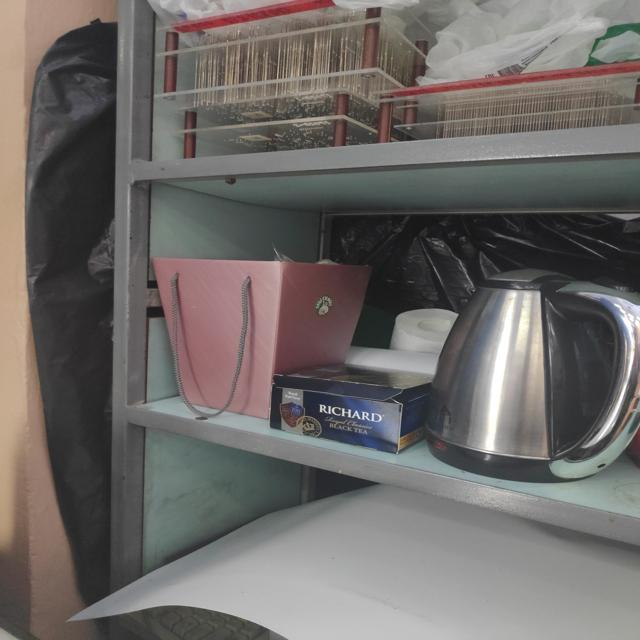

In [14]:
img = Image.open('/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/train/train/aaashhimmhraddpwwizz.jpg')
img

### ***Conclusion:*** Type of variable in the target values is ```float64``` with two unique values - 0, 1. This is fine for solving classification problem, but the target should be converted into ```string``` type. Number of observations if 2664. The target dataset is balanced.

# 2 Laplacian Algorithm for Blurred Image Detection

In [15]:
def variance_of_laplacian_blur(image, threshold):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    result = cv2.Laplacian(image, cv2.CV_64F).var()
    print(f' Laplacian result: {result}')
    if result < threshold:
        return 1
    else:
        return 0

In [16]:
def create_dataframe(path_folder: str, threshold):
    df_map = {'filename':[], 'blur':[]}
    filenames = [f for f in os.listdir(path_folder) if os.path.isfile(os.path.join(path_folder, f))]
    for file in filenames: #type: str
        if 'jpg' in file or 'png' in file or 'jpeg' in file or 'JPG' in file:
            full_image_path = os.path.join(path_folder,file)
            image_array = cv2.imread(full_image_path)
            result = variance_of_laplacian_blur(image_array, threshold)
            print(f'img {file}: laplacian: {result}')
            df_map['filename'].append(file)
            df_map['blur'].append(result)
    df = pd.DataFrame(df_map)
    return df

In [17]:
result_laplacian = create_dataframe('/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/test/test/', 280)

In [18]:
result_laplacian.to_csv('/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/result_laplacian.csv', index=False)

In [19]:
test_pred_laplacian = pd.read_csv('/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/result_laplacian.csv')
test_pred_laplacian

,filename,blur


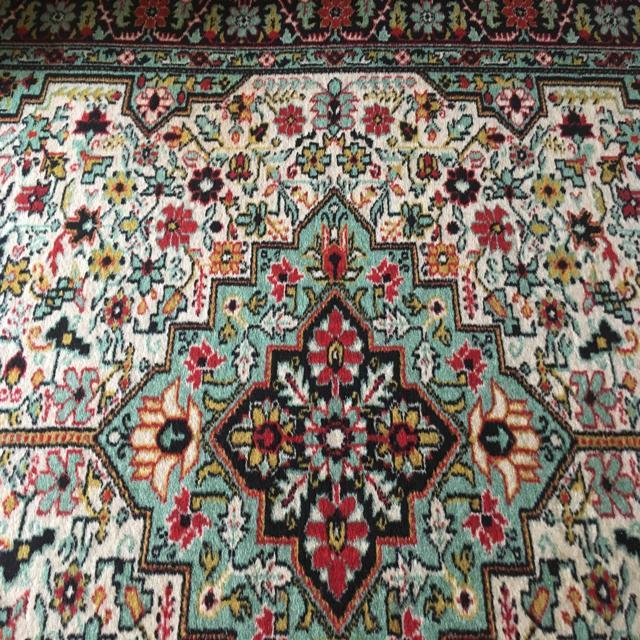

In [20]:
# manual testing - correct, 0=sharp
img_test = Image.open('/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/test/test/test/aamnsxdfcsnrdkyczxnm.jpg')
img_test

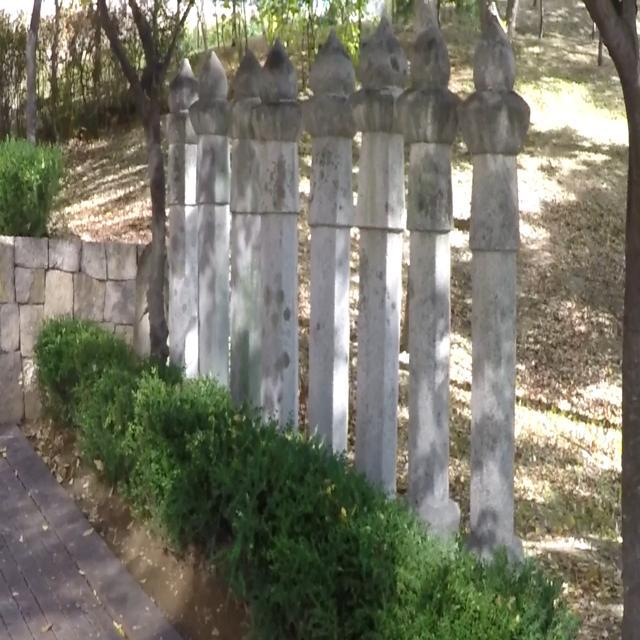

In [21]:
# manual testing - correct, 1=blurred
img_test = Image.open('/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/test/test/test/acgycwqzujjxrigweldc.jpg')
img_test

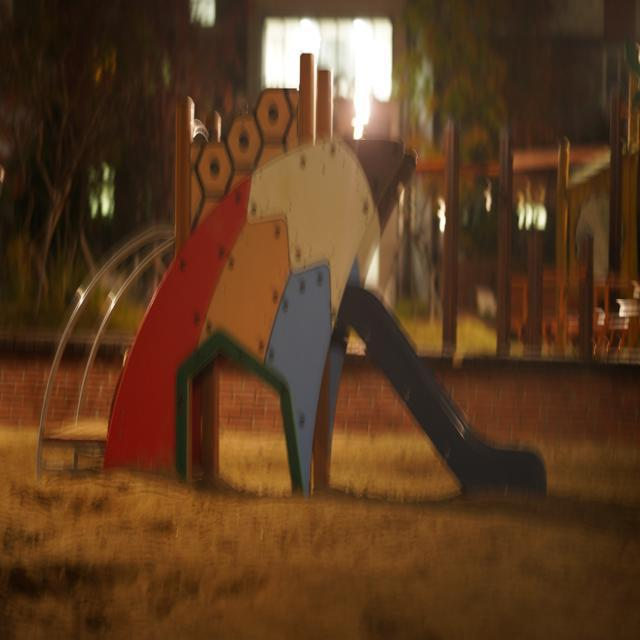

In [22]:
# manual testing - correct, 1=blurred
img_test = Image.open('/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/test/test/test/achfvibipchzipmhtjow.jpg')
img_test

# 3 Fitting the CNN models

## 3.1 Defining the function for loading the data, initiating and training a model

Data augmentation is used to prevent overfitting.

In [23]:
path = '/home/windows/Desktop/Blure_image_detection/ZAF056_CV_BlurredImage-detection/'

In [24]:
def load_train(path):
    labels = pd.read_csv(path + 'train.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'train/train/',
        x_col='filename',
        y_col='blur',
        target_size=(96, 96),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=5)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'train.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'train/train/',
        x_col='filename',
        y_col='blur',
        target_size=(96, 96),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=5)

    return test_gen_flow

In [25]:
train = load_train(path)

Found 1998 validated image filenames.


In [26]:
valid = load_test(path)

Found 666 validated image filenames.


### ***Conclusion:*** The functions for loading train and validation samples, creating and training the models are written, we can proceed with tuning different CNNs.

## 3.2 Creating and training different CNNs

In the CNN structure we add Dropout() regularization and BatchNormalization() layers.

- **BatchNormalization()** normalizes the activations of the previous layer at each batch, by subtracting the batch mean and dividing by the batch standard deviation. This helps to stabilize the learning process and allow higher learning rates, as well as reducing the chances of the model getting stuck in the saddle points or local optima.

- **Dropout()** is a regularization technique where some neurons are randomly dropped out during training. This helps to reduce overfitting by preventing complex co-adaptations on training data. The dropout rate is the fraction of neurons that are dropped out, usually between 0.2 and 0.5. At test time, no neurons are dropped out, but the weights are scaled by the dropout rate to balance the effect of missing neurons.

In [27]:
input_shape = (96, 96, 3)

In [28]:
STEP_SIZE_TRAIN=train.n//train.batch_size
STEP_SIZE_VALID=valid.n//valid.batch_size

## Model 1

In [29]:
def Build_CNN_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(2, 2), activation ='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization()) # added
    model.add(Conv2D(64, kernel_size = (2,2), activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization()) # added
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0001) # updated to lr=0.0001

    model.compile(loss = "binary_crossentropy", 
              optimizer=optimizer, metrics=['accuracy'])
    return model

## Model 2

In [30]:
def Build_CNN_model_2(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) # regularization
    
    model.add(BatchNormalization()) # added
#     model.add(Conv2D(64, (3, 3), padding='same'))
#     model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25)) # regularization
    
    model.add(BatchNormalization()) # added
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='Adamax', 
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [31]:
# Initiating the model
model1 = Build_CNN_model(input_shape)

In [32]:
# Initiating the model
model2 = Build_CNN_model_2(input_shape)

In [33]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 95, 95, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 47, 47, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                        

In [34]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                      

In [35]:
%%time
history1 = model1.fit_generator(train,
          validation_data=valid,
          epochs=30,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/30


2023-03-31 18:00:29.419245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-03-31 18:00:37.472629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 - 10s - loss: 0.6605 - accuracy: 0.6943 - val_loss: 0.7267 - val_accuracy: 0.4969 - 10s/epoch - 156ms/step
Epoch 2/30
62/62 - 7s - loss: 0.3999 - accuracy: 0.8327 - val_loss: 0.7145 - val_accuracy: 0.5047 - 7s/epoch - 107ms/step
Epoch 3/30
62/62 - 7s - loss: 0.3322 - accuracy: 0.8683 - val_loss: 0.7186 - val_accuracy: 0.5203 - 7s/epoch - 108ms/step
Epoch 4/30
62/62 - 7s - loss: 0.2875 - accuracy: 0.8922 - val_loss: 0.5869 - val_accuracy: 0.6609 - 7s/epoch - 106ms/step
Epoch 5/30
62/62 - 6s - loss: 0.2256 - accuracy: 0.9191 - val_loss: 0.7059 - val_accuracy: 0.5906 - 6s/epoch - 105ms/step
Epoch 6/30
62/62 - 7s - loss: 0.1687 - accuracy: 0.9476 - val_loss: 1.0064 - val_accuracy: 0.5500 - 7s/epoch - 111ms/step
Epoch 7/30
62/62 - 7s - loss: 0.1769 - accuracy: 0.9369 - val_loss: 1.4394 - val_accuracy: 0.5328 - 7s/epoch - 106ms/step
Epoch 8/30
62/62 - 7s - loss: 0.1265 - accuracy: 0.9552 - val_loss: 1.2442 - val_accuracy: 0.5703 - 7s/epoch - 110ms/step
Epoch 9/30
62/62 - 7s - loss: 0.1

In [36]:
%%time
history2 = model2.fit_generator(train,
          validation_data=valid,
          epochs=30,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/30


2023-03-31 18:03:51.973663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-03-31 18:04:01.102111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 - 11s - loss: 0.8232 - accuracy: 0.6012 - val_loss: 0.6882 - val_accuracy: 0.5312 - 11s/epoch - 171ms/step
Epoch 2/30
62/62 - 10s - loss: 0.6851 - accuracy: 0.6714 - val_loss: 0.7395 - val_accuracy: 0.5125 - 10s/epoch - 154ms/step
Epoch 3/30
62/62 - 10s - loss: 0.5705 - accuracy: 0.7467 - val_loss: 2.2666 - val_accuracy: 0.5000 - 10s/epoch - 155ms/step
Epoch 4/30
62/62 - 10s - loss: 0.4964 - accuracy: 0.7884 - val_loss: 2.7143 - val_accuracy: 0.5063 - 10s/epoch - 156ms/step
Epoch 5/30
62/62 - 10s - loss: 0.4409 - accuracy: 0.8164 - val_loss: 3.4734 - val_accuracy: 0.5031 - 10s/epoch - 156ms/step
Epoch 6/30
62/62 - 10s - loss: 0.3878 - accuracy: 0.8362 - val_loss: 3.2331 - val_accuracy: 0.5063 - 10s/epoch - 158ms/step
Epoch 7/30
62/62 - 10s - loss: 0.3234 - accuracy: 0.8749 - val_loss: 3.8266 - val_accuracy: 0.5078 - 10s/epoch - 157ms/step
Epoch 8/30
62/62 - 10s - loss: 0.3159 - accuracy: 0.8611 - val_loss: 1.8824 - val_accuracy: 0.5203 - 10s/epoch - 158ms/step
Epoch 9/30
62/62 - 

In [37]:
%%time
history3 = model2.fit_generator(train,
          validation_data=valid,
          epochs=50,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/50


2023-03-31 18:09:02.328670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-03-31 18:09:11.987544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 - 11s - loss: 0.1140 - accuracy: 0.9568 - val_loss: 0.3789 - val_accuracy: 0.8797 - 11s/epoch - 182ms/step
Epoch 2/50
62/62 - 11s - loss: 0.1132 - accuracy: 0.9608 - val_loss: 0.3532 - val_accuracy: 0.8844 - 11s/epoch - 177ms/step
Epoch 3/50
62/62 - 11s - loss: 0.1267 - accuracy: 0.9491 - val_loss: 0.6742 - val_accuracy: 0.7937 - 11s/epoch - 179ms/step
Epoch 4/50
62/62 - 11s - loss: 0.1396 - accuracy: 0.9491 - val_loss: 0.3774 - val_accuracy: 0.8750 - 11s/epoch - 173ms/step
Epoch 5/50
62/62 - 11s - loss: 0.1100 - accuracy: 0.9593 - val_loss: 0.3293 - val_accuracy: 0.8969 - 11s/epoch - 172ms/step
Epoch 6/50
62/62 - 11s - loss: 0.1103 - accuracy: 0.9542 - val_loss: 0.3742 - val_accuracy: 0.8703 - 11s/epoch - 185ms/step
Epoch 7/50
62/62 - 11s - loss: 0.0985 - accuracy: 0.9629 - val_loss: 0.7024 - val_accuracy: 0.7922 - 11s/epoch - 172ms/step
Epoch 8/50
62/62 - 14s - loss: 0.1142 - accuracy: 0.9557 - val_loss: 0.4332 - val_accuracy: 0.8578 - 14s/epoch - 221ms/step
Epoch 9/50
62/62 - 

In [35]:
%%time
history4 = model2.fit_generator(train,
          validation_data=valid,
          epochs=100,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=1)

Epoch 1/100


2023-03-31 21:30:19.087452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - ETA: 0s - loss: 0.8194 - accuracy: 0.6160

2023-03-31 21:30:31.232968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


62/62 [==============================] - 14s 215ms/step - loss: 0.8194 - accuracy: 0.6160 - val_loss: 0.8209 - val_accuracy: 0.4953
Epoch 2/100
62/62 [==============================] - 12s 187ms/step - loss: 0.6153 - accuracy: 0.7284 - val_loss: 0.9018 - val_accuracy: 0.5000
Epoch 3/100
62/62 [==============================] - 11s 175ms/step - loss: 0.5303 - accuracy: 0.7675 - val_loss: 0.9275 - val_accuracy: 0.5250
Epoch 4/100
62/62 [==============================] - 11s 176ms/step - loss: 0.4885 - accuracy: 0.7981 - val_loss: 1.1789 - val_accuracy: 0.5188
Epoch 5/100
62/62 [==============================] - 11s 181ms/step - loss: 0.4852 - accuracy: 0.8057 - val_loss: 1.1602 - val_accuracy: 0.5328
Epoch 6/100
62/62 [==============================] - 11s 181ms/step - loss: 0.4036 - accuracy: 0.8316 - val_loss: 1.6880 - val_accuracy: 0.5063
Epoch 7/100
62/62 [==============================] - 11s 182ms/step - loss: 0.3590 - accuracy: 0.8474 - val_loss: 1.0089 - val_accuracy: 0.5813
Epoc

62/62 [==============================] - 12s 185ms/step - loss: 0.0742 - accuracy: 0.9720 - val_loss: 0.3726 - val_accuracy: 0.8828
Epoch 58/100
62/62 [==============================] - 12s 186ms/step - loss: 0.0836 - accuracy: 0.9674 - val_loss: 0.3933 - val_accuracy: 0.8813
Epoch 59/100
62/62 [==============================] - 12s 186ms/step - loss: 0.0948 - accuracy: 0.9634 - val_loss: 0.4286 - val_accuracy: 0.8859
Epoch 60/100
62/62 [==============================] - 12s 187ms/step - loss: 0.0902 - accuracy: 0.9690 - val_loss: 0.3881 - val_accuracy: 0.8766
Epoch 61/100
62/62 [==============================] - 12s 186ms/step - loss: 0.0789 - accuracy: 0.9705 - val_loss: 0.3656 - val_accuracy: 0.8734
Epoch 62/100
62/62 [==============================] - 12s 187ms/step - loss: 0.0679 - accuracy: 0.9761 - val_loss: 0.3461 - val_accuracy: 0.8844
Epoch 63/100
62/62 [==============================] - 12s 186ms/step - loss: 0.0979 - accuracy: 0.9654 - val_loss: 0.3308 - val_accuracy: 0.882

In [36]:
model2.save("model.h5")

## 3.3 Choosing the best CNN model

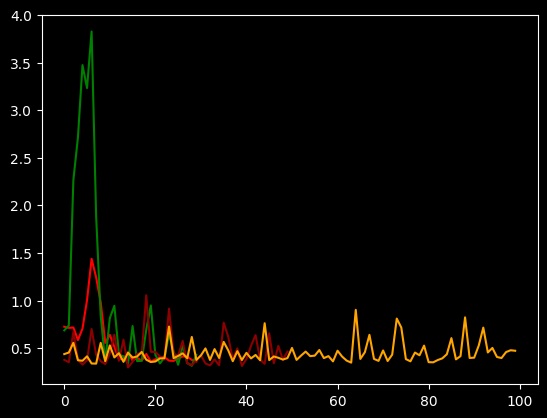

In [42]:
plt.plot(history1.history['val_loss'], 'r', 
         history2.history['val_loss'], 'g', 
         history3.history['val_loss'], 'darkred', 
         history4.history['val_loss'], 'orange');

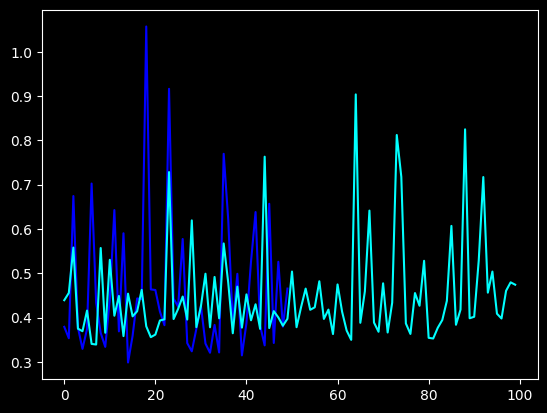

In [43]:
plt.plot(history3.history['val_loss'], 'b',
         history4.history['val_loss'], 'cyan');

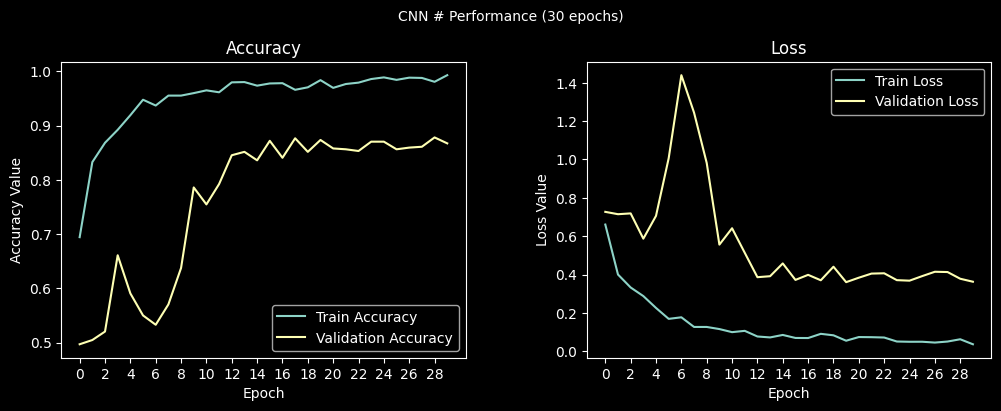

In [44]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN # Performance (30 epochs)', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 30))
ax1.plot(epoch_list, history1.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history1.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 30, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history1.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

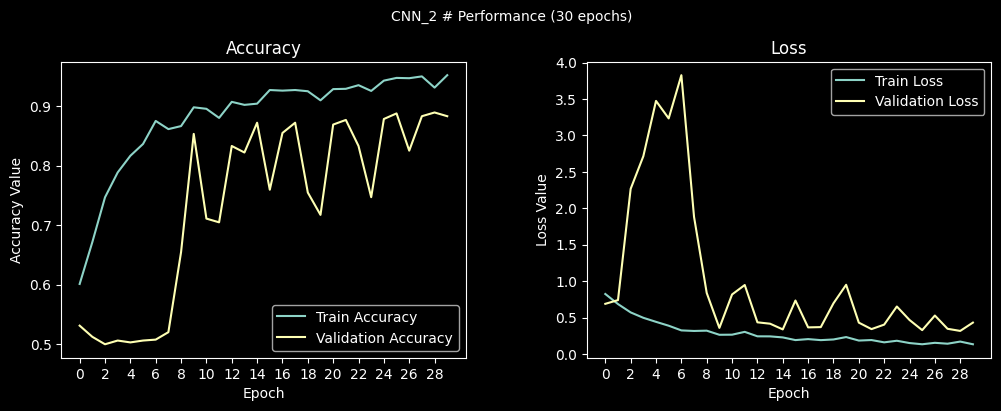

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN_2 # Performance (30 epochs)', fontsize=10)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 30))
ax1.plot(epoch_list, history2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history2.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 30, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

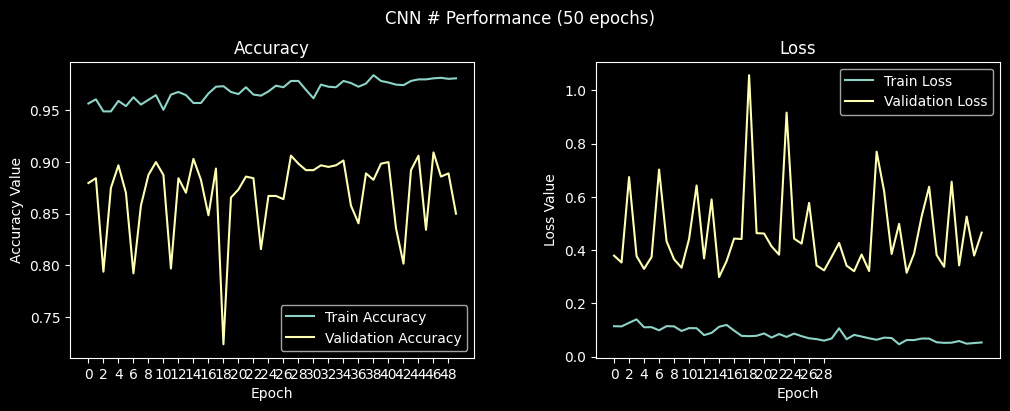

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN # Performance (50 epochs)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 50))
ax1.plot(epoch_list, history3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history3.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 50, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 30, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

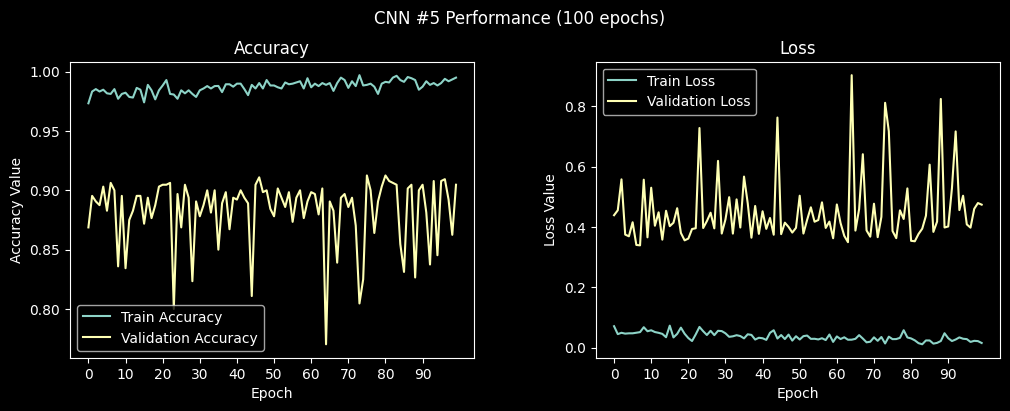

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN #5 Performance (100 epochs)', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0, 100))
ax1.plot(epoch_list, history4.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history4.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 100, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history4.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history4.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 100, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")